In [1]:
import os
import time

import matplotlib.pyplot as plt
import pandas as pd
from pandarallel import pandarallel
from rdkit.Chem import PandasTools, QED

In [2]:
# taken from https://github.com/rdkit/rdkit/issues/2279
import sys
from rdkit.Chem import RDConfig

sys.path.append(RDConfig.RDContribDir)

from NP_Score import npscorer

In [3]:
fscore = npscorer.readNPModel()
def score_np(mol):
    return npscorer.scoreMol(mol, fscore)

reading NP model ...
model in


In [4]:
def get_scores(filepath):
    df = pd.read_csv(filepath)
    # if any(x in file for x in ["chembl", "drugbank"]):
    #     df = df.sample(n=5000, random_state=2025)
    PandasTools.AddMoleculeColumnToFrame(df, smilesCol="taut_smiles")
    if len(df) > 1000:
        pandarallel.initialize(nb_workers=6, progress_bar=True)
        df["NP_likeness"] = df["ROMol"].parallel_apply(score_np)
        df["QED"] = df["ROMol"].parallel_apply(QED.default)
    else:
        df["NP_likeness"] = df["ROMol"].apply(score_np)
        df["QED"] = df["ROMol"].apply(QED.default)
    cols = [df.columns[0]] + ["NP_likeness", "QED"]
    return df[cols]


In [5]:
BASE_PATH = os.path.dirname(os.getcwd())

files = [f for f in os.listdir(os.path.join(BASE_PATH, "data", "processed")) 
         if f.endswith("cleaned.csv")]
files

['compounds_GreinerL_cleaned.csv',
 'chembl_35_NP_cleaned.csv',
 'enamine_advanced_50k_subset_cleaned.csv',
 'drugbank_5_1_13_cleaned.csv']

In [6]:
start = time.time()
scores = []
for file in files:
    name = file.split("_")[0]
    path = os.path.join(BASE_PATH, "data", "processed", file)
    df = get_scores(path)
    df.insert(1, "dataset", [name] * len(df))
    df.rename(columns={df.columns[0]: "ID"}, inplace=True)
    scores.append(df)

scores = pd.concat(scores, axis=0)
end = time.time()

print(f"Total execution time: {end - start :.2f} s")

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Total execution time: 207.77 s


In [7]:
scores.head()

,ID,dataset,NP_likeness,QED
0,5a,compounds,0.142383,0.677247
1,5b,compounds,-0.154070,0.647160
2,5c,compounds,-0.075949,0.594882
3,5d,compounds,0.040467,0.535276
4,5e,compounds,-0.226544,0.554405


In [8]:
scores.to_csv(os.path.join(BASE_PATH, "data", "processed", "scores.csv"),
              index=False)

In [ ]:
scores["nNP_likeness"] = 0
scores["nQED"] = 0
for name, group in scores.groupby("dataset"):
    

In [9]:
order = {}
for name, group in scores.groupby("dataset"):
    l = scores.dataset.apply(len).max() + 1
    print(f"{name :10}: {len(group)}")
    order[name] = len(group)

order = {k: v for k, v in sorted(order.items(), key=lambda item: item[1], reverse=True)}

order

chembl    : 78163
compounds : 22
drugbank  : 11307
enamine   : 49970


{'chembl': 78163, 'enamine': 49970, 'drugbank': 11307, 'compounds': 22}

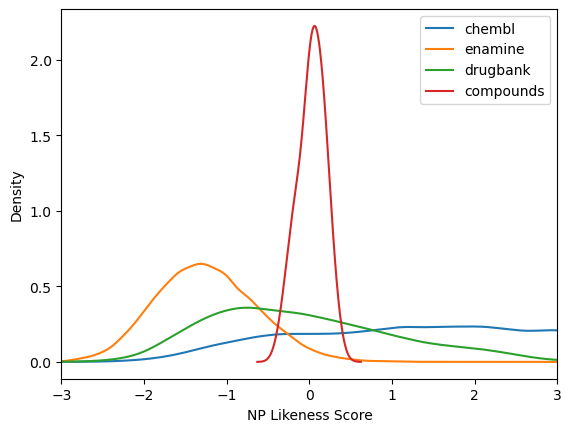

In [ ]:
fig = plt.figure()
for data in order.keys():
    scores.query("dataset == @data")["NP_likeness"].plot.density(label=data)

plt.xlabel("NP Likeness Score")
plt.xlim((-3,3))
plt.legend()
plt.show()

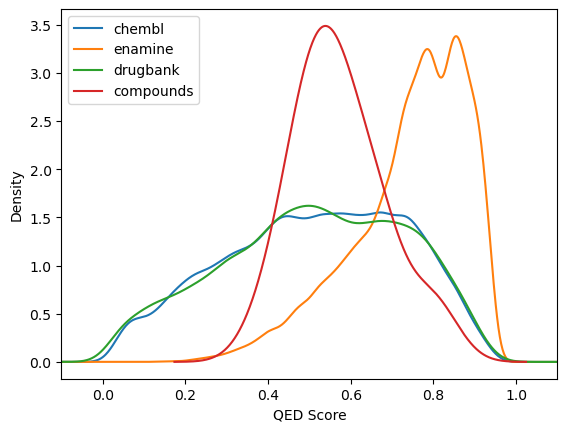

In [11]:
fig = plt.figure()
for data in order.keys():
    scores.query("dataset == @data")["QED"].plot.density(label=data)

plt.xlabel("QED Score")
plt.xlim((-0.1,1.1))
plt.legend()
plt.show()

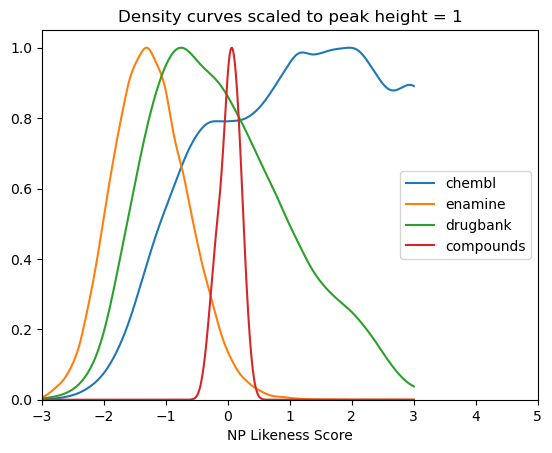

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

x_vals = np.linspace(-3, 3, 500)

fig = plt.figure()

for data in order.keys():
    values = scores.query("dataset == @data")["NP_likeness"].dropna()
    kde = gaussian_kde(values)
    y = kde(x_vals)
    y_scaled = y / y.max()  # scale so the max y-value becomes 1
    plt.plot(x_vals, y_scaled, label=data)

plt.xlabel("NP Likeness Score")
plt.xlim((-3, 5))
plt.ylim(0, 1.05)  # All curves now peak at 1
plt.legend()
plt.title("Density curves scaled to peak height = 1")
plt.show()
